In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio
import os
import time

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

import sys
sys.path.append("../")
from pyfiles.dataset import Parallelo2oVCMelDataset, ParallelArcticDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import numpy as np
import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
setup = 0

if setup==0: ### Accent Addition
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    # src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"
    # trg_dir = "/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/BDL/ASI/"
elif setup==1: ### Accent Removal
    # cosyvoice
    # src_dir = f"/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/ASI/"
    # trg_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/ASI/English/"
    # elevenlabs
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
elif setup==2: ### Speaker Voice conversion
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"

scaler = {}
scaler_filename = f"ckpts/scalers/LibriTTS-R_16000.save"
scaler["mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_wavlm.save"
scaler["wavlm"] = joblib.load(scaler_filename)

In [63]:
### Direct Conversion
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_accentaddition_gt2syn_melmel_small_cutsilence/checkpoint-60000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_accentaddition_gt2syn_melmel_smaller_cutsilence/checkpoint-500000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_gt2synAR_melmel_smaller/checkpoint-20000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_gt2synAAcosy_melmel_small/checkpoint-100000steps.pkl"

### VTN Fine-tuning
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small/checkpoint-5000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small_formerfreeze_lr0.00001/checkpoint-200000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small_lr0.00001/checkpoint-190000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small_decoderfreeze_lr0.00001/checkpoint-45000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small_guidedattn_lr0.00001/checkpoint-200000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_small_guidedattn_formerfreeze_lr0.00001/checkpoint-40000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2mixAA_melmel_small/checkpoint-50000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synAAcosy_melmel_smaller/checkpoint-50000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synAAcosy_melmel_small/checkpoint-100000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synAAcosy_melmel_hubert_norepeating_small/checkpoint-100000steps.pkl"
checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_hubert_norepeating_smaller/checkpoint-100000steps.pkl"
checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_hubert_norepeating_small/checkpoint-100000steps.pkl"
checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_melmel_hubert_norepeating/checkpoint-100000steps.pkl"

### VTN Accent Removal
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synAR_melmel_small/checkpoint-50000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_syn2gtARcosy_melmel_hubert_norepeating_small/checkpoint-100000steps.pkl"

### VC
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_sltbdlVC_melmel_small_lr0.00001/checkpoint-35000steps.pkl"

if "smaller" in checkpoint_path:
    size = "smaller"
elif "small" in checkpoint_path:
    size = "small"
else:
    size = ""

args = {}
args["rank"] = 0
args["checkpoint"] = checkpoint_path
args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.melmel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

# Customization
if "nocondition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "nocondition"
elif "addition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "add"
elif "concatenation" in checkpoint_path:
    config["model_params"]["conditiontype"] = "concat"

In [64]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
# dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "train", input_output=["mel", "mel"], noembedding=True)
dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "test", input_output=["mel", "mel"], noembedding=True)

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
# fs = 24000
fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_vocos(config_path, model_path, fs)

100 /mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/


In [65]:
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        utt_id = os.path.basename(dataset.files[idx-1]).split(".")[0]
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        gt = batch["trg_feat"]
        gt = torch.tensor(gt, dtype=torch.float).to(device)
        xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
        yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
        config_inference = config["inference"].copy()
        config_inference["maxlenratio"] = config_inference["maxlenratio"]*gt.shape[0]/x.shape[0]
        outs, probs, att_ws = model.inference(
            x, config_inference, xembs, yembs, spemb=None
        )

        # plot figures
        plot_generated_and_ref_2d(
            outs.cpu().numpy(),
            config["outdir"] + f"/outs/{utt_id}.png",
            origin="lower",
        )
        
        plot_1d(
            probs.cpu().numpy(),
            config["outdir"] + f"/probs/{utt_id}_prob.png",
        )
        plot_attention(
            att_ws.cpu().numpy(),
            config["outdir"] + f"/att_ws/{utt_id}_att_ws.png",
        )
        
        ### Waveform ###
        if not os.path.exists(os.path.join(config["outdir"], "wav")):
            os.makedirs(os.path.join(config["outdir"], "wav"), exist_ok=True)
        denormalized_mel = scaler["mel"].inverse_transform(cuda2numpy(outs))
        y = vocoder.decode(torch.tensor(denormalized_mel.T).unsqueeze(0))
        sf.write(
            os.path.join(config["outdir"], "wav", f"{utt_id}.wav"),
            y.cpu().numpy()[0],
            fs,
            "PCM_16",
        )
        
        ### Mel ###
        if not os.path.exists(os.path.join(config["outdir"], "mel")):
            os.makedirs(os.path.join(config["outdir"], "mel"), exist_ok=True)
            
        denormalized_input_mel = scaler["mel"].inverse_transform(x.cpu().numpy())
        denormalized_gt_mel = scaler["mel"].inverse_transform(gt.cpu().numpy())
        np.save(os.path.join(config["outdir"], "mel", f"output_{utt_id}.npy"), denormalized_mel)
        np.save(os.path.join(config["outdir"], "mel", f"gt_{utt_id}.npy"), denormalized_gt_mel)
        np.save(os.path.join(config["outdir"], "mel", f"input_{utt_id}.npy"), denormalized_input_mel)
        np.save(os.path.join(config["outdir"], "probs", f"probs_{utt_id}.npy"), probs.cpu().numpy())
        np.save(os.path.join(config["outdir"], "att_ws", f"attws_{utt_id}.npy"), att_ws.cpu().numpy())
        if idx>2:
            break

[decode]:   2%|▏         | 2/100 [00:10<08:58,  5.50s/it]


# Check the result

source


ground truth


predicted


<AxesSubplot: title={'center': 'attention weight'}>

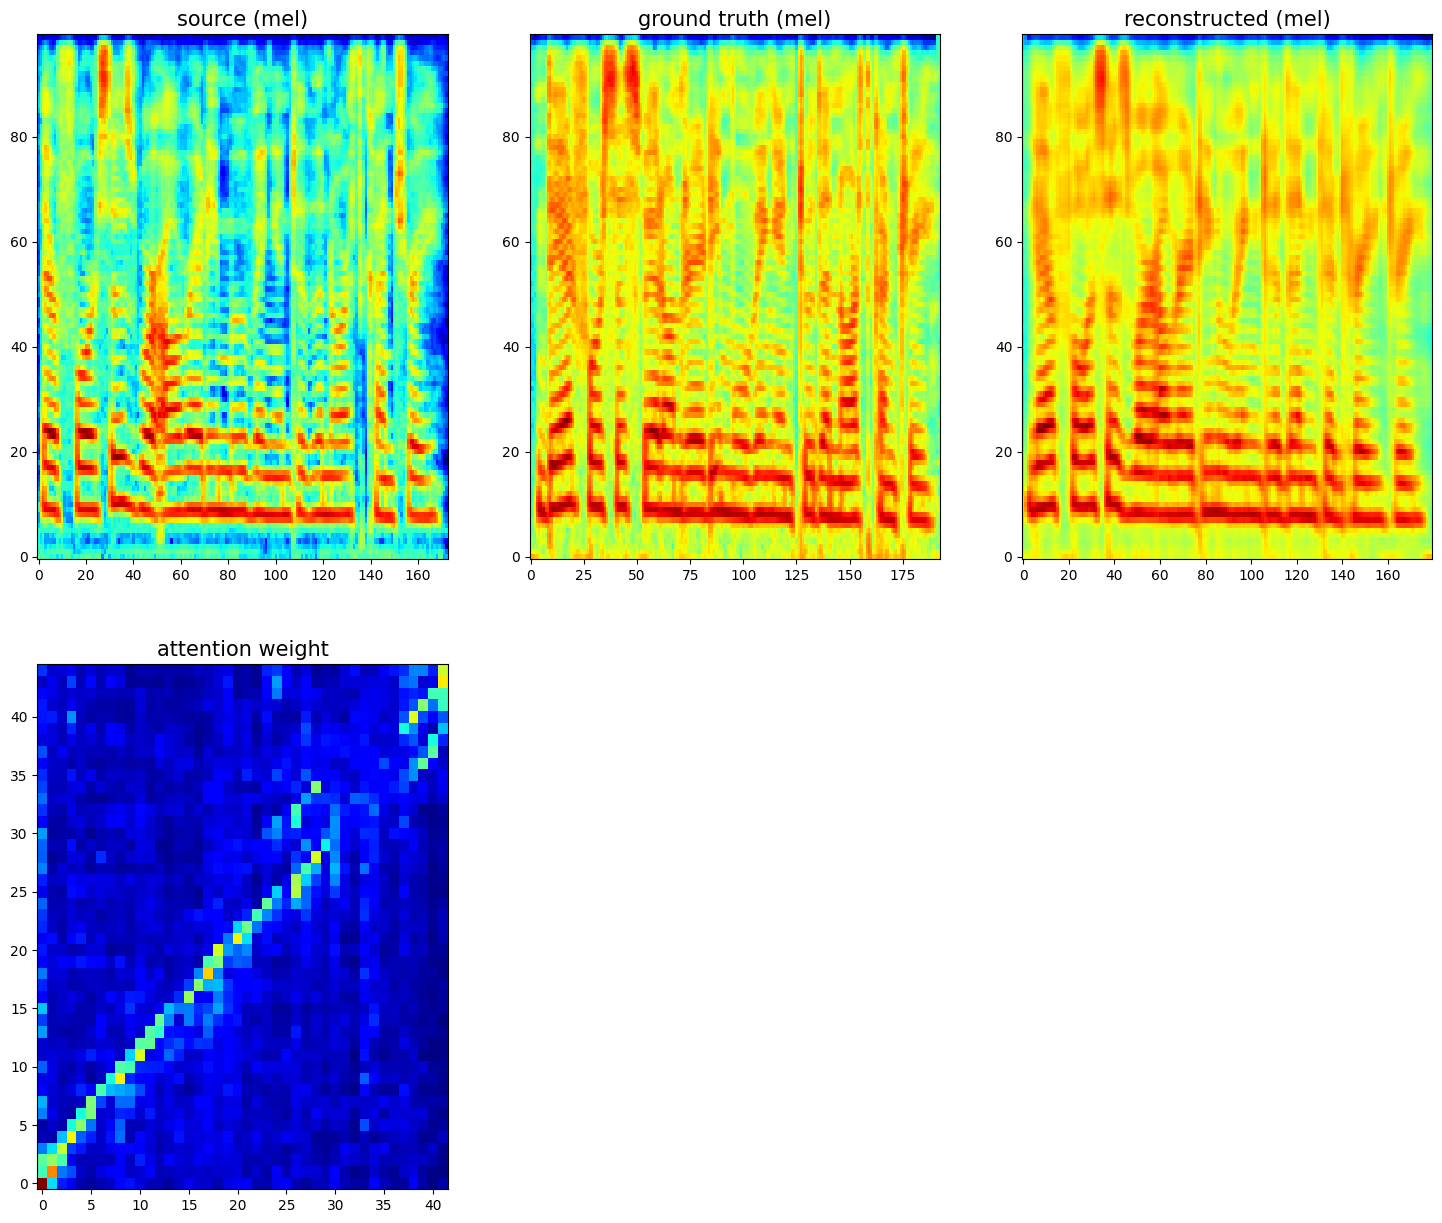

In [66]:
utt_id = dataset.files[1]
utt_basename = utt_id
data = dataset[dataset.files.index(utt_id)]

imelpath = os.path.join(config["outdir"], "mel", f"input_{utt_basename}.npy")
omelpath = os.path.join(config["outdir"], "mel", f"output_{utt_basename}.npy")
gtmelpath = os.path.join(config["outdir"], "mel", f"gt_{utt_basename}.npy")
wavpath = os.path.join(config["outdir"], "wav", f"{utt_basename}.wav")
predmel = np.load(omelpath)
predwav, sr = torchaudio.load(wavpath)

gtmel = np.load(gtmelpath)
gtwav = vocoder.decode(torch.tensor(gtmel.T).unsqueeze(0))
sourcemel = np.load(imelpath)
sourcewav = vocoder.decode(torch.tensor(sourcemel.T).unsqueeze(0))

%matplotlib inline  
fig = plt.figure(figsize=(18, 15))
print("source")
play_audio(sourcewav, fs)
print("ground truth")
play_audio(gtwav, fs)
print("predicted")
play_audio(predwav, sr)

plot_spectrogram(sourcemel.T, fig, (2,3,1), title=f"source (mel)")
plot_spectrogram(gtmel.T, fig, (2,3,2), title="ground truth (mel)")
plot_spectrogram(predmel.T, fig, (2,3,3), title="reconstructed (mel)")

probs = np.load(os.path.join(config["outdir"], "probs", f"probs_{utt_basename}.npy"))
attws = np.load(os.path.join(config["outdir"], "att_ws", f"attws_{utt_basename}.npy"))
att = np.array([attws[i][j] for i in range(attws.shape[0]) for j in range(attws.shape[1])]).mean(0)
plot_spectrogram(att, fig, (2,3,4), title="attention weight")